# How to measure similarity or dissimilarity between two data set?


In this notebook, we deal with the problem of determining how similar are two datasets. 

### Keywords

MMD,similarity

### Objective

Understand how we can and can not determine the similarity between datasets.

### Methodology

We use some datasets that are obtained from measuring temperature and humidity using sensors and different devices. The dataset is obtained from this website.

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import torch
import itertools
import os

In [41]:
datasets_path="../datasets/"

# Possible values Data_Experiment_1, Data_Experiment_2, GNFUV-USV-Dataset
dataset="Data_Experiment_1"

# Create the final path to get the files
file_path=datasets_path+dataset

# Obtain a list of all the files in the path
files = glob.glob(file_path + "/*.xlsx")

# Combines all the devices datasets information into a huge dataset
pi_d = []

# Dictionary to assign each node with their dataset
samples={}

# Read all the files and prepare the dataframe
n=1
for file in files:
    pi_dx = pd.read_excel(file)
    print("======"+os.path.basename(file).split('.')[0])
    # Clean the dataset deleating the None values
    pi_dx = pi_dx.replace(to_replace=' None', value=np.nan).dropna()
    
    # Ensure type of the numeric columns 
    pi_dx["Humidity"]=pi_dx["Humidity"].astype(float)
    pi_dx["Temperature"]=pi_dx["Temperature"].astype(float)
    
    # Cleanning useless cols
    del pi_dx['Experiment']
 
    
    samples[os.path.basename(file).split('.')[0]]=pi_dx
    pi_d.append(pi_dx)
    
    print(pi_dx.describe())
    print("======")
    n=n+1

pi_df = pd.concat(pi_d)

# Ensure type of the numeric columns 
pi_df["Humidity"]=pi_df["Humidity"].astype(float)
pi_df["Temperature"]=pi_df["Temperature"].astype(float)

# When we concat dataset, index must be duplicated, so it is better to reset them
pi_df=pi_df.reset_index()
del pi_df['index']

# Get a summary of the final dataset
#print(pi_df.nunique())
print(pi_df.describe())

======pi3
         Humidity  Temperature
count  899.000000   899.000000
mean    43.040044    28.525028
std      6.173310     4.387950
min     34.000000    19.000000
25%     38.000000    25.000000
50%     40.000000    31.000000
75%     46.000000    32.000000
max     59.000000    33.000000
======pi2
          Humidity  Temperature
count  1532.000000  1532.000000
mean     27.599869    35.851828
std      11.081249     6.571685
min      15.000000     3.000000
25%      19.000000    33.000000
50%      21.500000    39.000000
75%      35.000000    41.000000
max      57.000000    45.000000
======pi5
          Humidity  Temperature
count  2078.000000  2078.000000
mean     39.775746    27.508181
std       6.899635     5.103708
min      20.000000    18.000000
25%      34.000000    23.000000
50%      40.000000    27.000000
75%      43.000000    32.000000
max      63.000000    37.000000
======pi4
          Humidity  Temperature
count  1766.000000  1766.000000
mean     28.201586    35.469989
std      

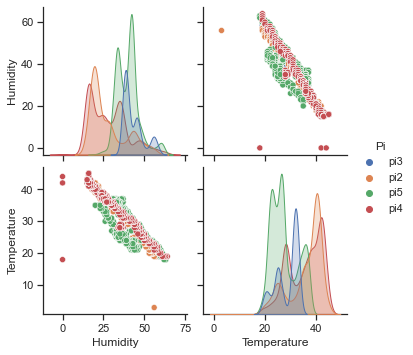

In [42]:
sns.set_theme(style="ticks")
sns.pairplot(pi_df, hue="Pi")

If we analyze the dataset * Data_Experiment_1 * we can see how the datasets pi2 and pi4 have quite similar distributions.

Since we want to analyze all combinations of datasets, we will make a method to get all the pairs in a list.

In [20]:
# Get all pairs from a list
def get_all_pairs(l):
    res = [(a, b) for idx, a in enumerate(l) for b in l[idx + 1:]]
    return res

# initializing list
t = ['p1', 'p2', 'p3', 'p4']
expected = [('p1', 'p2'), ('p1', 'p3'), ('p1', 'p4'), ('p2', 'p3'), ('p2', 'p4'), ('p3', 'p4')]

res = get_all_pairs(t)

assert res == expected, "Test failed."


In [73]:
def getScore(elem):
    return elem[2]

target="Humidity"
#target="Temperature"
scores = []
for x,y in get_all_pairs([k  for  k in  samples.keys()]):
    mean_x = samples[x][target].mean()
    mean_y = samples[y][target].mean()
    res = abs(mean_x - mean_y)
    scores.append([x,y,res])
   # print ("|mean("+ str(x) +") - " + "mean("+ str(x) + ")| = " + str(res) )
scores.sort(key=getScore)
print(scores)

[['pi2', 'pi4', 0.6017160522666316], ['pi3', 'pi5', 3.2642985843537033], ['pi5', 'pi4', 11.57416040556463], ['pi2', 'pi5', 12.175876457831261], ['pi3', 'pi4', 14.838458989918333], ['pi3', 'pi2', 15.440175042184965]]


At this point, we have analyzed the distance between the different distributions considering the horizontal distance between the distributions (average). This fact is incorrect, as we do not consider the vertical space. **Explanation:** Imagine two completely different distributions vertically but identical horizontally. This remaining average will give us 0, erroneously indicating that the distributions are the same.

### Maximum Mean Discrepancy (MMD)

**Maximum Mean Discrepancy (MMD)** is a distance on the space of probability measures which has found numerous applications in machine learning and nonpara- metric testing. This distance is based on the notion of embedding probabilities in a reproducing kernel Hilbert space.

In [60]:
from sklearn import metrics
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

a = np.arange(1, 5).reshape(2, 2)
b = [[7, 6], [4, 3], [1, 1], [0, 2]]
b = np.array(b)
expected=0.5492989092810665
#print(a)
#print(b)
#print(mmd_rbf(a, b))
assert mmd_rbf(a, b) == expected, "Test failed."

0.5492989092810665


In [74]:
def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)

In [75]:
def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [81]:
def getScore(elem):
    return elem[2]

scores_rbf = []
scores_linear = []
scores_polyy = []
for x,y in get_all_pairs([k  for  k in  samples.keys()]):
    sx = samples[x][['Temperature', 'Humidity']].values.tolist()
    sy = samples[y][['Temperature', 'Humidity']].values.tolist()
    res_rbf = mmd_rbf(sx, sy)
    scores_rbf.append([x,y,res])
scores_rbf.sort(key=getScore)
print(scores_rbf)

[['pi3', 'pi2', 11.57416040556463], ['pi3', 'pi5', 11.57416040556463], ['pi3', 'pi4', 11.57416040556463], ['pi2', 'pi5', 11.57416040556463], ['pi2', 'pi4', 11.57416040556463], ['pi5', 'pi4', 11.57416040556463]]
